## xgboost results

This notebook contains the results from xgboost.

- XGBoost was first optmized with a very small grid (trees and learning rate)
- afterwards the selected features were used within a larger grid search space

We want to have the following results:
1. Results of the cross-validation
2. Results of the train / test split
3. SHAP results
4. interactions
5. target / decoys

Methods:
TBD

In [80]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CONT_AVG_tiny.p", "rb"))
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_OH_AVG_tiny.p", "rb"))

data_dic.keys()
#dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

## Train-Test Split

The following table summarizes the metrics for training on 80% of the data and then predicting on the other 20%.


In [81]:
metrics_df = data_dic["metrics"]
metrics_df.round(2)

,r2,pearsonr,MAE,MSE,split
0,0.80,0.90,3.88,25.62,Train
1,0.52,0.72,5.75,56.77,Validation
2,0.42,0.70,5.56,49.15,DX


## Best features:

Using mlxtend and the nested SequentialFeatureSelector + GridSearch the following features get choosen through a parsimony criterium:

In [82]:
features = data_dic["best_features_gs"]
features

Index(['length2', 'charge_3', 'charge_4', 'charge_5', 'charge_6', 'charge_7',
       'aromatics', 'charge_cmp', 'helix', 'pi', 'charge_glob',
       'hydrophobic_ratio', 'intrinsic_size_sum', 'intrinsic_size_max',
       'mv_size_std', 'polarity_size_max', 'secondstruc_sum',
       'secondstruc_size_max', 'static_size_max', 'm/z'],
      dtype='object')

# Cross-validation results

The CV was done using 3splits and negative_mean_squared_error as metric.

In [83]:
df_cv = data_dic["summary_gs"]
df_cv = df_cv.sort_values("rank_test_score", ascending=True)
print(df_cv.head())
best_cv = df_cv
best_cv
#print(best_cv)
best_df = df_cv.filter(regex="split|rank")
best_df

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      395.411820      9.397805         0.008062        0.001122   
7      394.686899      8.468561         0.005077        0.000563   
10     394.927884      9.180607         0.005182        0.000702   
11     395.365182      8.869005         0.008814        0.000871   
9      394.694362      8.459488         0.002309        0.000294   

   param_xgb__learning_rate param_xgb__n_estimators param_xgb__nthread  \
8                       0.1                     100                  1   
7                       0.1                      50                  1   
10                      0.3                      50                  1   
11                      0.3                     100                  1   
9                       0.3                      10                  1   

   param_xgb__seed                                             params  \
8               42  {'xgb__learning_rate': 0.1, 'xgb__n_estimators...   


,split0_test_score,split1_test_score,split2_test_score,rank_test_score
8,-61.494135,-61.067415,-60.699561,1
7,-61.676279,-63.088693,-62.252347,2
10,-62.955363,-61.203378,-63.466868,3
11,-63.926906,-61.702461,-65.114207,4
9,-64.049453,-67.131630,-68.020084,5
6,-353.711981,-388.861755,-373.617100,6
5,-382.468081,-420.446051,-402.449737,7
4,-933.177267,-998.020236,-970.867445,8
3,-2005.777142,-2105.570719,-2067.387619,9
2,-2007.550160,-2107.339733,-2069.213115,10


## Train - Validation Evaluation

Evaluate the results when the model was trained on 80%.

In [84]:
predictions_df = data_dic["predictions_df"]
predictions_df

,predictions,observed,Split
0,-54.177624,-54.532691,Train
1,-47.921398,-42.752252,Train
2,-45.094738,-49.030737,Train
3,-49.211838,-48.037323,Train
4,-50.487179,-50.339742,Train
...,...,...,...
4507,-36.540684,-35.000650,DX
4508,-44.054737,-44.022716,DX
4509,-57.226315,-60.237317,DX
4510,-57.226315,-59.896068,DX


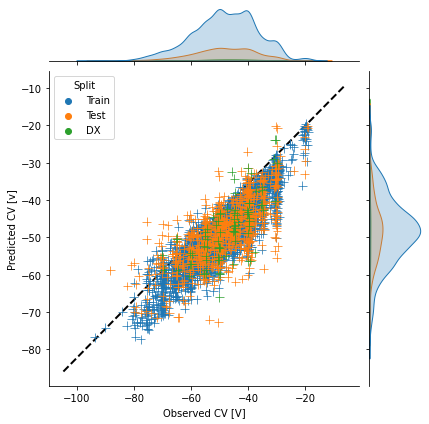

In [85]:
#fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df[predictions_df["Split"] != "DX"], marker="+", s=50)
fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80)
fax.ax_joint.set(xlabel="Observed CV [V]", ylabel="Predicted CV [v]")
x0, x1 = fax.ax_joint.get_xlim()
y0, y1 = fax.ax_joint.get_ylim()
fax.ax_joint.plot([x0, x1], [y0, y1], ls="--", zorder=-1, lw=2, c="k")

### SHAP Analysis
Use shap to determine:
1. most important parameters
2. interesting interactions

In [86]:
print("Loading model, train, val, dx features and best features")
# model
model = data_dic["xgb"]
print(data_dic["data"].keys())

# data consists of tuples with meta data and feature data
all_data = data_dic["data"]
TT_train, TT_train_features = all_data["TT_train"] 
TT_val, TT_val_features = all_data["TT_val"] 
DX = all_data["DX"] 
#print(all_data)

# use shortcut
X = TT_val_features[features]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values_inter = shap.TreeExplainer(model).shap_interaction_values(X)

Loading model, train, val, dx features and best features
dict_keys(['TT_train', 'TT_val', 'DX'])


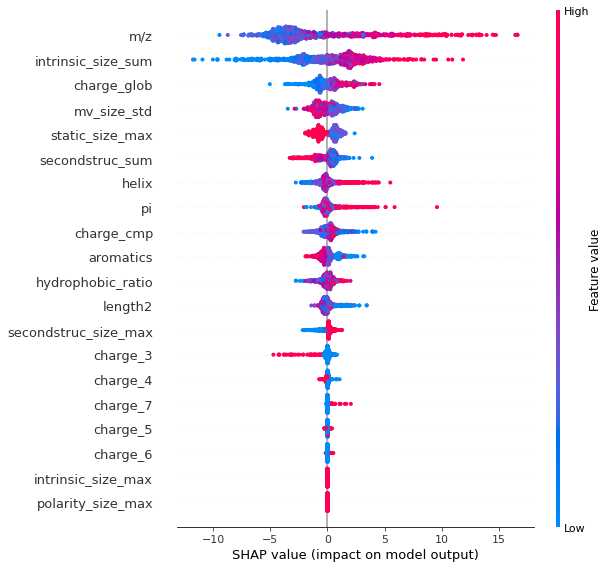

In [87]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

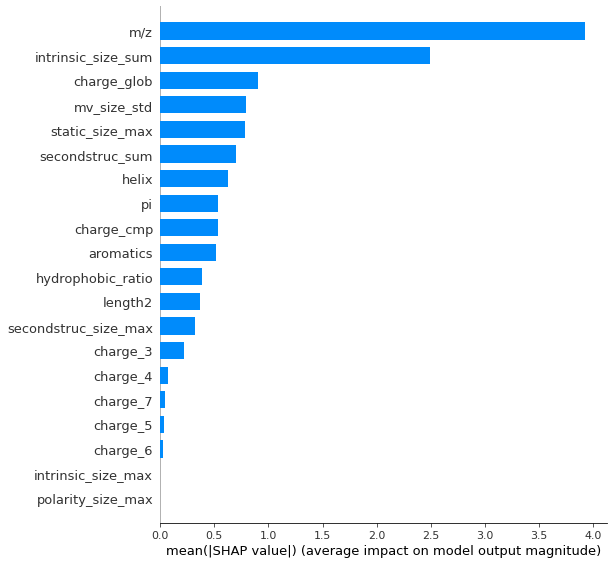

In [88]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [89]:
# shap viz
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [90]:
shap.force_plot(explainer.expected_value, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


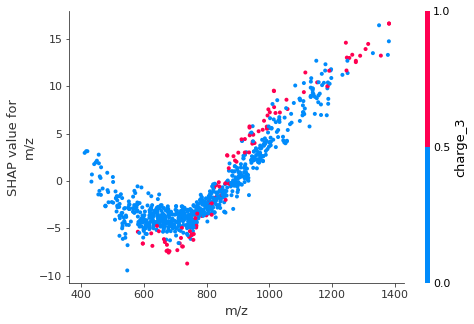

In [91]:
shap.dependence_plot("m/z", shap_values, X)